In [49]:
from hedge_stand import HedgeST
from datetime import date, datetime
from demeter import TokenInfo, PoolBaseInfo, Runner, Strategy, Asset, AccountStatus, BuyAction, SellAction, RowData, \
    ChainType
import optunity
import optunity.metrics
from decimal import Decimal
import pandas as pd
import  matplotlib.pylab as plt
# import logging 
# from logging import handlers

from strategy_ploter import  plot_position_return_decomposition

%matplotlib inline

def backtest_instance(a, hedge_spread_split,hedge_spread_rate,alpha):
    # global RUNNING_TIME
    # print(f"==================spread running time {RUNNING_TIME}==================")

    decimal_a = Decimal(a).quantize(Decimal('0.00'))
    decimal_hedge_spread_split = Decimal(hedge_spread_split).quantize(Decimal('0.0'))
    decimal_hedge_spread_rate = Decimal(hedge_spread_rate).quantize(Decimal('0.00'))

    pool_id_tie500 = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'

    pool_id_tie3000 = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'

    eth = TokenInfo(name="eth", decimal=18)
    usdc = TokenInfo(name="usdc", decimal=6)
    pool = PoolBaseInfo(usdc, eth, 0.05, usdc)

    #收益计算基础参数
    # net_value_base = 'ETH'

    runner_instance = Runner(pool)
    # runner_instance.enable_notify = False
    runner_instance.strategy = HedgeST(decimal_a,decimal_hedge_spread_split,decimal_hedge_spread_rate,alpha)
    runner_instance.set_assets([Asset(usdc, 10000)])
    runner_instance.data_path = "../demeter/data"
    runner_instance.load_data(ChainType.Ethereum.name,
                                pool_id_tie500,
                                DATE_START,
                               DATE_END)
    runner_instance.run(enable_notify=False)

    hedge_count = runner_instance.strategy.hedge_count


    # df_status = pd.DataFrame(runner_instance.account_status_list)

    total_net_value = runner_instance.final_status.net_value
    
    final_total_usdc_value = round(total_net_value + runner_instance.strategy.e.df['total'].iloc[-1],3)
    
    final_price = runner_instance.final_status.price

    final_total_eth_value = round(final_total_usdc_value / final_price,3)

    notice = f"backtest spread:{RUNNING_TIME} times, a:{decimal_a}, hedge_spread_split:{decimal_hedge_spread_split}, hedge_spread_rate:{decimal_hedge_spread_rate},alpa:{alpha}"
    result =f"result: hedge count:{hedge_count} final_total_eth_value:{final_total_eth_value},final_total_usdc_value:{final_total_usdc_value}"
    print(notice)
    print(result)
    # if SEND_NOTICE:
    #     send_notice('CEX_Notify',notice)

    # RUNNING_TIME +=1

    # if NET_VALUE_BASE == 'USDC':
    #     print(final_total_usdc_value)
    #     return float(final_total_usdc_value)
    #     # profit_rate_usdc = profit_usdc / runner_instance.strategy.init_total_usdc
    # else:
    #     print(float(final_total_usdc_value / final_price))
    #     return float(final_total_usdc_value / final_price)


    return runner_instance





In [50]:

def generate_dfmerge(instance):
    e = runner_instance.strategy.e

    total_net_value = runner_instance.final_status.net_value
        
    final_total_usdc_value = total_net_value + runner_instance.strategy.e.df['total'].iloc[-1]


    final_price = runner_instance.final_status.price
    # if net_value_base == 'USDC':
    profit_usdc = round(final_total_usdc_value- runner_instance.strategy.init_total_usdc,3)
    profit_rate_usdc = round(profit_usdc / runner_instance.strategy.init_total_usdc,3)
    # else:
    profit_eth = round(final_total_usdc_value/final_price - runner_instance.strategy.init_total_symbol,3)
    profit_rate_eth = round(profit_eth / runner_instance.strategy.init_total_symbol,3)

    print(f"USDC profit: {profit_usdc}, profit_rate: {profit_rate_usdc}")

    print(f"ETH profit: {profit_eth}, profit_rate: {profit_rate_eth}")

    df_status = pd.DataFrame(runner_instance.account_status_list)
    df_merge = pd.merge(e.df, df_status, on='timestamp', how='inner')

    df_merge['total_value'] = df_merge['total'] + df_merge['net_value']

    df_merge.set_index('timestamp', inplace=True)

    df_merge['total_value_profit_rate'] = df_merge['total_value'] / runner_instance.strategy.init_total_usdc


    df_merge['total_value_eth'] = df_merge['total_value'] / df_merge['price']

    df_merge['total_value_eth_profit_rate'] = df_merge['total_value_eth'] / runner_instance.strategy.init_total_symbol

    return df_merge

In [51]:
import matplotlib.dates as mdates

def plot_instance(runner_instance, df_merge):

    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=7)
    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')
    # net_value_ts = df_merge['net_value']

    time_ts = df_merge.index
    price_ts = [ status.price for status in runner_instance.account_status_list ]
    total_value_eth_profit_rate_ts = df_merge['total_value_eth_profit_rate']
    total_value_profit_rate_ts = df_merge['total_value_profit_rate']


    value_ax.plot(time_ts,total_value_eth_profit_rate_ts,'g-',label="total_value_eth_profit_rate_ts")
    value_ax.plot(time_ts,total_value_profit_rate_ts,'r-',label="total_value_profit_rate_ts")
    #value_ax.plot(time_ts,value_in_account,'b-',label=" value_in broker account")
    price_ax.plot(time_ts,price_ts,label="price")
    fig.legend()
    fig.show()

2022-11-06 11:52:58,156 - INFO - start load files from 2022-10-01 to 2022-10-31...
2022-11-06 11:52:58,709 - INFO - load file complete, preparing...
2022-11-06 11:53:00,722 - INFO - data has benn prepared
2022-11-06 11:53:00,725 - INFO - init strategy...
2022-11-06 11:53:01,129 - INFO - start main loop...


add ema column with alpha 0.05
hedge rebalance ETH -3.763126540547189847650276885 1328.682399097044044780509581 profit: 0E-51
prepare to add LP: rate:1.20 price:1328.682399097044044780509581 down:1107.235332580870037317091318 up:1594.418878916452853736611497 init symbol amount:9.031503697313255717918859121,init usdc amount:12000.00000000000011102230246
eth_value 0 usdc value 0.118199317660808408870915


 40%|██████████████████████████████████████████▋                                                               | 17961/44640 [01:25<02:02, 216.94it/s]

2022-10-13 10:36:00 hedge sell ETH,trade price: 1233.914299316676806152856009,ema:1253.959880802667,trade amount: 1.003500410812583903107722159, profit: -356.62


 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 33041/44640 [03:27<01:24, 137.14it/s]

2022-10-23 22:18:00 hedge buy ETH, trade price:1351.056580923552763944051423,ema:1344.188409698667, trade amount:1.003500410812583903107722159, profit: -33.36


 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 35577/44640 [03:53<01:06, 135.77it/s]

2022-10-25 16:38:00 hedge buy ETH, trade price:1411.968364423030500372729360,ema:1409.3090461508689, trade amount:1.003500410812583903107722159, profit: 195.86


 80%|████████████████████████████████████████████████████████████████████████████████████▋                     | 35672/44640 [03:53<01:15, 118.56it/s]

2022-10-25 18:30:00 hedge buy ETH, trade price:1520.107482100572314629856266,ema:1481.0655513760569, trade amount:1.003500410812583903107722159, profit: 711.32


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                  | 36878/44640 [04:04<00:57, 136.14it/s]

2022-10-26 14:27:00 hedge buy ETH, trade price:1576.298267232872137656286625,ema:1554.992669507612, trade amount:1.003500410812583903107722159, profit: 1035.55


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉         | 40844/44640 [04:40<00:31, 119.19it/s]

2022-10-29 08:18:00 ema:1595.4203724641395 => last hedge buy ETH, 1618.140935294402998710399009, 0.752625308109437716334472834, 1318.98
remove lp position tick:202577,206224
2022-10-29 08:18:00 out of range, price:1618.140935294402998710399009,ema:1595.4203724641395 symbol:0, usdc:10474.79723010783807796500199
hedge rebalance ETH 4.170134014247843484141636110 1618.140935294402998710399009 profit: 1318.976776946532496392542494
prepare to add LP: rate:1.20 price:1618.140935294402998710399009,ema:1595.4203724641395, self.down_price:1348.450779412002498925332508,self.up_price 1941.769122353283598452478811 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [05:14<00:00, 141.82it/s]
2022-11-06 11:58:15,900 - INFO - main loop finished, start calculate evaluating indicator...
2022-11-06 11:58:15,986 - INFO - run evaluating indicator
2022-11-06 11:58:15,993 - INFO - back testing finish


backtest spread:1 times, a:1.20, hedge_spread_split:3.0, hedge_spread_rate:0.80,alpa:0.05
result: hedge count:6 final_total_eth_value:8.837,final_total_usdc_value:13907.191
USDC profit: 1907.191, profit_rate: 0.159
ETH profit: -0.195, profit_rate: -0.022


/var/folders/jx/963_5qrj3ld11sfdq7x6c69m0000gn/T/ipykernel_97637/1456322662.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


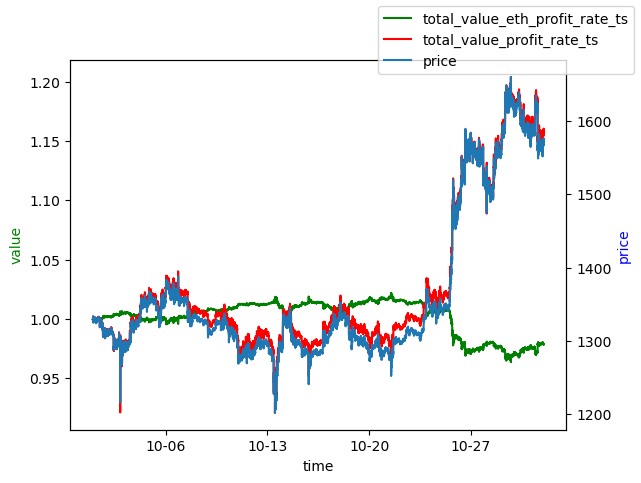

In [52]:
NET_VALUE_BASE = 'ETH'
RUNNING_TIME = 1
SEND_NOTICE = False
DATE_START = date(2022, 10, 1)
DATE_END = date(2022, 10, 31)


runner_instance=backtest_instance(1.2,3,0.8,0.05)

df_merge = generate_dfmerge(runner_instance)

plot_instance(runner_instance, df_merge)

2022-11-06 11:58:18,040 - INFO - start load files from 2022-10-01 to 2022-10-31...
2022-11-06 11:58:18,487 - INFO - load file complete, preparing...
2022-11-06 11:58:20,513 - INFO - data has benn prepared
2022-11-06 11:58:20,514 - INFO - init strategy...
2022-11-06 11:58:21,129 - INFO - start main loop...


add ema column with alpha 0.05
hedge rebalance ETH -3.763126540547189847650276885 1328.682399097044044780509581 profit: 0E-51
prepare to add LP: rate:1.20 price:1328.682399097044044780509581 down:1107.235332580870037317091318 up:1594.418878916452853736611497 init symbol amount:9.031503697313255717918859121,init usdc amount:12000.00000000000011102230246
eth_value 0 usdc value 0.118199317660808408870915


  6%|██████▌                                                                                                    | 2753/44640 [00:09<02:01, 344.14it/s]

2022-10-02 21:12:00 hedge sell ETH,trade price: 1216.152514177924893661505111,ema:1298.5363660960056,trade amount: 1.003500410812583903107722159, profit: -423.46


 11%|███████████▌                                                                                               | 4807/44640 [00:16<02:29, 266.95it/s]

2022-10-04 07:14:00 hedge buy ETH, trade price:1345.663417770351304698387711,ema:1339.3377468047286, trade amount:1.003500410812583903107722159, profit: -66.06


 40%|██████████████████████████████████████████▌                                                               | 17912/44640 [01:13<02:42, 164.28it/s]

2022-10-13 10:22:00 hedge sell ETH,trade price: 1248.060696286064413585462539,ema:1271.291617436997,trade amount: 1.003500410812583903107722159, profit: -433.35


 44%|██████████████████████████████████████████████▍                                                           | 19557/44640 [01:23<02:32, 164.51it/s]

2022-10-14 13:27:00 hedge buy ETH, trade price:1344.721830050661560106805995,ema:1336.413630672734, trade amount:1.003500410812583903107722159, profit: -166.61


 48%|██████████████████████████████████████████████████▊                                                       | 21402/44640 [01:34<01:55, 200.83it/s]

2022-10-15 20:10:00 hedge sell ETH,trade price: 1240.843255922531661795743246,ema:1279.7153206759522,trade amount: 1.003500410812583903107722159, profit: -557.51


 55%|██████████████████████████████████████████████████████████▎                                               | 24550/44640 [01:53<01:50, 182.22it/s]

2022-10-18 00:40:00 hedge buy ETH, trade price:1352.543486466657106900472369,ema:1337.5841386622017, trade amount:1.003500410812583903107722159, profit: -249.26


 66%|██████████████████████████████████████████████████████████████████████▏                                   | 29566/44640 [02:29<01:24, 177.92it/s]

2022-10-21 12:14:00 hedge sell ETH,trade price: 1252.185893158814003356547891,ema:1273.886171519819,trade amount: 1.003500410812583903107722159, profit: -626.92


 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 33032/44640 [02:54<01:22, 140.78it/s]

2022-10-23 22:00:00 hedge buy ETH, trade price:1345.394325451317786627884267,ema:1333.839576267909, trade amount:1.003500410812583903107722159, profit: -369.70


 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 35540/44640 [03:13<01:09, 130.96it/s]

2022-10-25 15:52:00 hedge buy ETH, trade price:1415.219466443012207426439728,ema:1395.6715995291445, trade amount:1.003500410812583903107722159, profit: -106.94


 80%|████████████████████████████████████████████████████████████████████████████████████▋                     | 35662/44640 [03:14<01:04, 138.69it/s]

2022-10-25 17:57:00 hedge buy ETH, trade price:1481.984864867640109158301977,ema:1463.241513480216, trade amount:1.003500410812583903107722159, profit: 211.31


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                  | 36880/44640 [03:23<00:54, 142.32it/s]

2022-10-26 14:13:00 hedge buy ETH, trade price:1556.251226502792960618536728,ema:1536.9764758225924, trade amount:1.003500410812583903107722159, profit: 639.83


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 38213/44640 [03:34<00:48, 131.69it/s]

====>low:1618.302749387932439010270048, self.up_price:1594.418878916452853736611497
2022-10-27 12:36:00 none ema=>last hedge buy ETH, 1594.418878916452853736611497, trade_amount: 0.752625308109437716334472834, current_amount: 0.4538316003320072113639015535


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 39025/44640 [03:40<00:36, 152.98it/s]

2022-10-28 01:53:00 hedge sell ETH,trade price: 1474.888736648379248251887945,ema:1517.6865372168847,trade amount: 1.003500410812583903107722159, profit: -1.25


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 40667/44640 [03:55<00:53, 74.32it/s]

====>low:1595.805484034260388589714541, self.up_price:1594.418878916452853736611497
2022-10-29 05:26:00 none ema=>last hedge buy ETH, 1594.418878916452853736611497, trade_amount: 1.003500410812583903107722159, current_amount: 0.003941144659982575699049599852
====>low:1600.759908708436920419100835, self.up_price:1594.418878916452853736611497
remove lp position tick:202577,206224
2022-10-29 05:27:00 out of range, price:1596.124661089122081010036370,ema:1581.8820882397672 symbol:0, usdc:10474.79723010783807796500199
hedge rebalance ETH 4.125210049529420045216324031 1596.124661089122081010036370 profit: 791.2554599231446778805062530
prepare to add LP: rate:1.20 price:1596.124661089122081010036370,ema:1581.8820882397672, self.down_price:1330.103884240935067508363642,self.up_price 1915.349593306946497212043644 


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▎        | 40963/44640 [03:58<00:26, 137.87it/s]

2022-10-29 10:16:00 hedge buy ETH, trade price:1641.445415390662928278434954,ema:1631.776570153572, trade amount:1.003500410812583903107722159, profit: 945.39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [04:29<00:00, 165.72it/s]
2022-11-06 12:02:50,498 - INFO - main loop finished, start calculate evaluating indicator...
2022-11-06 12:02:50,685 - INFO - run evaluating indicator
2022-11-06 12:02:50,687 - INFO - back testing finish


backtest spread:1 times, a:1.20, hedge_spread_split:3.0, hedge_spread_rate:0.80,alpa:-1
result: hedge count:13 final_total_eth_value:8.549,final_total_usdc_value:13454.932
USDC profit: 1454.932, profit_rate: 0.121
ETH profit: -0.482, profit_rate: -0.053


/var/folders/jx/963_5qrj3ld11sfdq7x6c69m0000gn/T/ipykernel_97637/1456322662.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


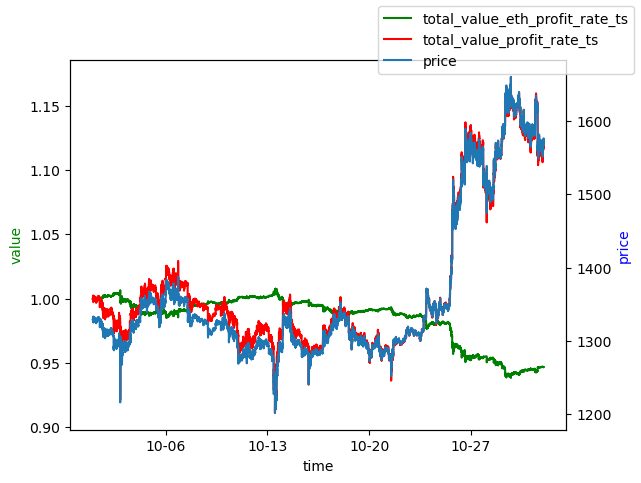

In [53]:
runner_instance=backtest_instance(1.2,3,0.8,-1)

df_merge = generate_dfmerge(runner_instance)

plot_instance(runner_instance, df_merge)